In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
#from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, plot_roc_curve, plot_confusion_matrix

In [88]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head(10)
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [89]:
df = pd.concat([train, test], axis=0, ignore_index=True)

In [90]:
# dfを分割する前にIDを保存
test_id = df[df['Survived'].isnull()]['PassengerId'].values

In [91]:
def kesson_hyou(df):
  null_sum = df.isnull().sum()
  percent = 100 * null_sum / len(df)
  kesson_table = pd.concat([null_sum,percent],axis=1)
  kesson_code = kesson_table.rename(columns = {0:'欠損数', 1:'%'})
  return kesson_code


kesson_hyou(test)

,欠損数,%
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,86,20.574163
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,1,0.239234
Cabin,327,78.229665


In [92]:
#train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna("S")
train['Fare'] = train['Fare'].fillna(train['Fare'].median())#なかったから除外
#test['Age'] = test['Age'].fillna(test['Age'].median())
#test.Fare[152] = test.Fare.median()
test['Embarked'] = test['Embarked'].fillna("S")
fare = test.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3),'Fare'].median()#この処理本当はやりたい
test['Fare'] = test['Fare'].fillna(df['Fare'].median())

# df から直接補完
df.loc[df['Fare'].isnull(), 'Fare'] = df['Fare'].median()

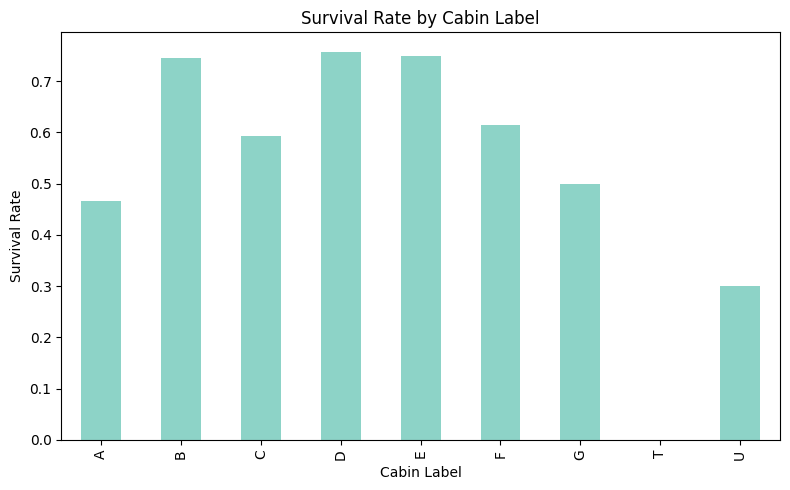

In [93]:
# Cabin の欠損値を 'Unknown' に置き換え
df['Cabin'] = df['Cabin'].fillna('Unknown')

# 先頭1文字を Cabin_label として抽出（例：C123 → 'C'）
df['Cabin_label'] = df['Cabin'].str[0]

# ラベルごとの生存率を計算
cabin_survival = df.groupby('Cabin_label')['Survived'].mean()

# 棒グラフを描画
ax = cabin_survival.plot.bar(
    figsize=(8, 5),
    xlabel="Cabin Label",
    ylabel="Survival Rate",
    title="Survival Rate by Cabin Label",
    colormap="Set3"
)

plt.tight_layout()
plt.show()

In [94]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Ageを予測するための特徴量
age_df = df[['Age','Pclass','Sex','Parch','SibSp']]
age_df = pd.get_dummies(age_df)

# 欠損なし／ありで分ける
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データを準備
x = known_age[:, 1:]  
y = known_age[:, 0]

# モデル構築＆予測
tree = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
tree.fit(x, y)
hokan_data = tree.predict(unknown_age[:, 1:])

# 欠損を df に対して一括補完！
df.loc[df['Age'].isnull(), 'Age'] = hokan_data

# train/test 再分割
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()].drop('Survived', axis=1)


In [95]:
print(train['Age'].isnull().sum())  # → 0 ならOK
print(test['Age'].isnull().sum())  # → 0 ならOK

0
0


/var/folders/wg/8g8ccmdj7gv2xtpjb991yrfh0000gn/T/ipykernel_48003/1477432158.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Honorifics'] = (


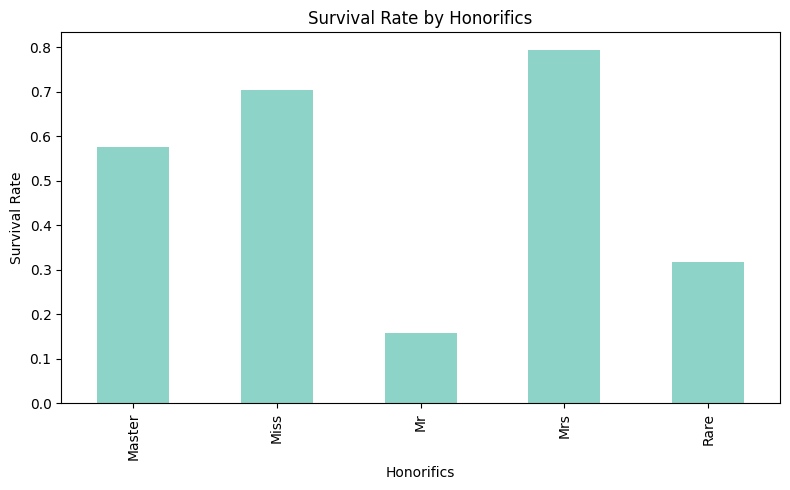

In [96]:
Honorifics_Dict = {
    "Capt": "Rare",
    "Col": "Rare",
    "Don": "Rare",
    "Dr": "Rare",
    "Major": "Rare",
    "Rev": "Rare",
    "Jonkheer": "Rare",
    "Dona": "Rare",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Rare",
    "Countess": "Rare",
    "Sir": "Rare"
}

# 1. 敬称の抽出・グループ化（既に実装済みの前処理部分）
train['Honorifics'] = (
    train['Name']
    .apply(lambda x: x.split(',')[1].split('.')[0].strip())
    .map(Honorifics_Dict)
)

# 2. 敬称ごとの生存率を計算
survival_rates = train.groupby("Honorifics")["Survived"].mean()

# 3. 棒グラフを作成
ax = survival_rates.plot.bar(
    figsize=(8, 5),
    xlabel="Honorifics",
    ylabel="Survival Rate",
    title="Survival Rate by Honorifics",
    colormap="Set3"  # pandas の場合はこちらを使います :contentReference[oaicite:7]{index=7}
)

# 4. グラフ表示
plt.tight_layout()
plt.show()


In [97]:
# ------------ Surname ------------
# NameからSurname(苗字)を抽出
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 

In [98]:

#Fmale_Chiled_Group = df.loc[(df['FamilyGroup'] >= 2) & ((df['Age'] <= 16)  | (df['Sex'] == 'Female'))]
#Male_Adult_Group = df.loc[(df['FamilyGroup'] >= 2) & ((df['Age'] > 16) & (df['Sex'] == 'Male'))]
#Female_Child_Group = Fmale_Chiled_Group.groupby('Surname')['Survived'].mean()
#Male_Adult_Group = Male_Adult_Group.groupby('Surname')['Survived'].mean()
#print(Female_Child_Group.value_counts())

In [99]:
import pandas as pd

# train のみを対象に
#df = train.copy()

# Surname 抽出＆グループ定義
df['Surname']     = df['Name'].str.split(',').str[0].str.strip()
df['FamilyGroup'] = df.groupby('Surname')['Surname'].transform('size')

# 女子かつ子ども（Age<=16 AND female）グループ
female_child_df = df.loc[
    (df['FamilyGroup'] >= 2) &
    (df['Age'] <= 16) &
    (df['Sex'] == 'female')
]

# 大人男性（Age>16 AND male）グループ
male_adult_df = df.loc[
    (df['FamilyGroup'] >= 2) &
    (df['Age'] > 16) &
    (df['Sex'] == 'male')
]

# 苗字ごとの生存率計算（角括弧で列を選択）
female_child_rates = female_child_df.groupby('Surname')['Survived'].mean()
male_adult_rates   = male_adult_df.groupby('Surname')['Survived'].mean()

# 結果表示
print(f"女子かつ子どもグループ数: {len(female_child_rates)}")
print(f"  生存率100%グループ数: {(female_child_rates == 1.0).sum()}")
print(f"  生存率0%グループ数:  {(female_child_rates == 0.0).sum()}")

print(f"大人男性グループ数:   {len(male_adult_rates)}")
print(f"  生存率100%グループ数: {(male_adult_rates == 1.0).sum()}")
print(f"  生存率0%グループ数:  {(male_adult_rates == 0.0).sum()}")

女子かつ子どもグループ数: 46
  生存率100%グループ数: 25
  生存率0%グループ数:  12
大人男性グループ数:   199
  生存率100%グループ数: 21
  生存率0%グループ数:  115


In [100]:
# デッドリストとサバイブリストの作成
Dead_list=set(female_child_rates[female_child_rates.apply(lambda x:x==0)].index)
Survived_list=set(male_adult_rates[male_adult_rates.apply(lambda x:x==1)].index)

# デッドリストとサバイブリストの表示
print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

Dead_list =  {'Palsson', 'Goodwin', 'Allison', 'Lefebre', 'Boulos', 'Andersson', 'Ford', 'Van Impe', 'Zabour', 'Skoog', 'Strom', 'Sage'}
Survived_list =  {'Daly', 'Harder', 'McCoy', 'Chambers', 'Moubarek', 'Goldenberg', 'Nakid', 'Beckwith', 'Bishop', 'Greenfield', 'Beane', 'Frauenthal', 'Jonsson', 'Cardeza', 'Bradley', 'Jussila', 'Frolicher-Stehli', 'Taylor', 'Kimball', 'Duff Gordon', 'Dick'}


In [101]:

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
            ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
            ['Sex','Age','Title']] = ['female',5.0,'Mrs']

In [102]:
def kesson_hyou(df):
  null_sum = df.isnull().sum()
  percent = 100 * null_sum / len(df)
  kesson_table = pd.concat([null_sum,percent],axis=1)
  kesson_code = kesson_table.rename(columns = {0:'欠損数', 1:'%'})
  return kesson_code


kesson_hyou(test)

,欠損数,%
PassengerId,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0
Cabin,0,0.0


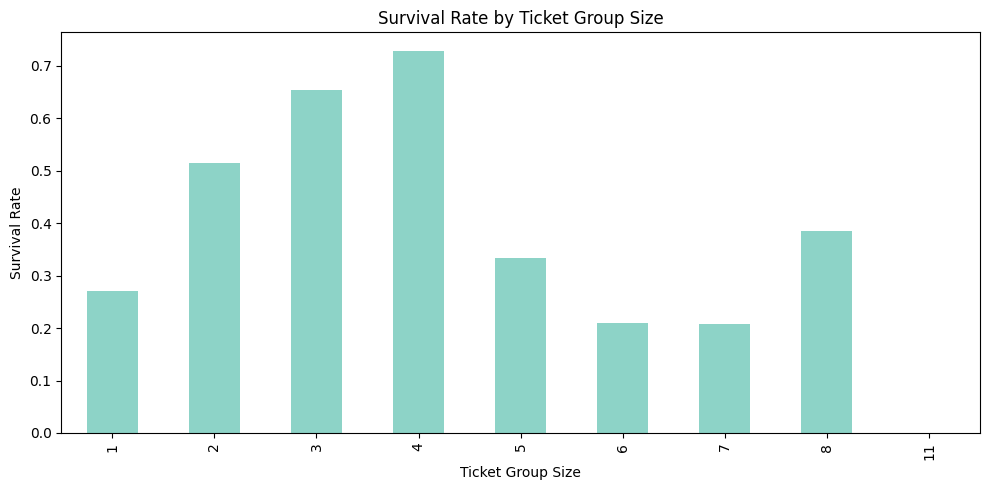

In [103]:
# 同一Ticketナンバーの人数を数える
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)

# TicketGroup ごとの平均生存率を計算
survival_rates_fam = df.groupby('TicketGroup')['Survived'].mean()

# 棒グラフの描画（pandasベース）
dx = survival_rates_fam.plot.bar(
    figsize=(10, 5),
    xlabel="Ticket Group Size",
    ylabel="Survival Rate",
    title="Survival Rate by Ticket Group Size",
    colormap="Set3"
)

plt.tight_layout()
plt.show()

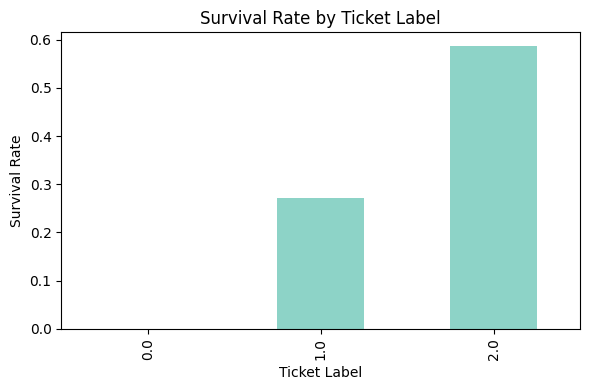

In [104]:
# TicketGroup から Ticket_label を作成
df.loc[(df['TicketGroup'] >= 2) & (df['TicketGroup'] <= 4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup'] >= 5) & (df['TicketGroup'] <= 8) | (df['TicketGroup'] == 1), 'Ticket_label'] = 1
df.loc[(df['TicketGroup'] >= 11), 'Ticket_label'] = 0

# Ticket_label ごとの生存率を計算（NaN除外）
ticket_label_survival = df.dropna(subset=['Ticket_label']).groupby('Ticket_label')['Survived'].mean()

# 棒グラフを描画
cx = ticket_label_survival.plot.bar(
    figsize=(6, 4),
    xlabel="Ticket Label",
    ylabel="Survival Rate",
    title="Survival Rate by Ticket Label",
    colormap="Set3"
)

plt.tight_layout()
plt.show()

In [105]:
# ----------- Family -------------
# Family = SibSp + Parch + 1 を特徴量とし、グルーピング
df['Family']=df['SibSp']+df['Parch']+1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0

In [106]:
# ------------- 前処理 ---------------
# 推定に使用する項目を指定
df = df[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','Cabin_label','Ticket_label']]

# ラベル特徴量をワンホットエンコーディング
df = pd.get_dummies(df)

# データセットを trainとtestに分割
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()].drop('Survived',axis=1)

# データフレームをnumpyに変換
X = train.values[:,1:]  
y = train.values[:,0] 
test_x = test.values

In [107]:
# test_x を DataFrame にしてから確認
test_df = pd.DataFrame(test_x)
print(test_df.isnull().sum())      # 列ごとのNaN数
print(test_df.isnull().sum().sum())  # 全体のNaNの総数





0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
dtype: int64
0


In [111]:
print(test.columns[2])  # index 2 の列名を確認
y = y.astype(int)



Fare


In [112]:
# ----------- 推定モデル構築 ---------------
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

# 採用する特徴量を25個から20個に絞り込む
select = SelectKBest(k = 20)

clf = RandomForestClassifier(random_state = 10, 
                            warm_start = True,  # 既にフィットしたモデルに学習を追加 
                            n_estimators = 26,
                            max_depth = 6, 
                            max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

# フィット結果の表示
cv_result = cross_validate(pipeline, X, y, cv= 10)
print('mean_score = ', np.mean(cv_result['test_score']))
print('mean_std = ', np.std(cv_result['test_score']))

/Users/ayuma2479/data/データサイエンス/titanic/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/ayuma2479/data/データサイエンス/titanic/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/ayuma2479/data/データサイエンス/titanic/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/ayuma2479/data/データサイエンス/titanic/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/ayuma2479/data/データサイエンス/titanic/.venv/lib/python3.13/site-packages/sklearn/featu

mean_score =  0.837278401997503
mean_std =  0.04173898113916931


In [114]:
# 予測
predictions = pipeline.predict(test_x)

# 提出ファイルの作成
submission = pd.DataFrame({
    "PassengerId": test_id,
    "Survived": predictions.astype(np.int32)
})
submission.to_csv("my_submission_Re80.csv", index=False)
